In [53]:
from google.colab import drive
drive.mount('/content/gdrive/')
path = "/content/gdrive/My Drive/Colab Notebooks"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [54]:
import re, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [55]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib

In [56]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

from fastai.tabular import *
from fastai.tabular.all import *
from fastai.tabular.data import *
from fastai.tabular.learner import *

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [58]:
data = pd.read_csv(path+"/data_shuf.csv")
alist = data.columns.to_list()
alist

['pop2012',
 'night2012',
 'road_len',
 'cen_dist',
 'city_pop_total',
 'land_cover']

In [59]:
data.describe()

,pop2012,night2012,road_len,cen_dist,city_pop_total,land_cover
count,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000,433774.000000
mean,0.008004,0.020648,0.071480,0.214999,0.192048,6.906518
std,0.032205,0.042011,0.093311,0.142153,0.301218,1.857292
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.001736,0.000000,0.115120,0.021847,7.000000
50%,0.000061,0.004673,0.046930,0.182038,0.036372,7.000000
75%,0.001265,0.017724,0.104343,0.279313,0.141055,8.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000


In [60]:
cat_names = alist[-1]
cont_names = alist[1:-1]
y_names = alist[0]
procs = [Categorify,]

In [61]:
percent, length = 0.8, len(data.axes[0])
stop = int(percent * length)
splits = [list(range(stop)), list(range(stop,length))]

In [62]:
cont,cat = cont_cat_split(data, 1, dep_var=y_names)
to = TabularPandas(data, procs, cat, cont, y_names=y_names, splits=splits)

In [63]:
len(to.xs),len(to.train),len(to.valid)

(433774, 347019, 86755)

In [64]:
xs, y = to.xs,to.y
train_xs,train_y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

## Decision Tree

In [65]:
def rmse(y,y_pred): return mean_squared_error(y,y_pred,squared=False)

In [66]:
dt = DecisionTreeRegressor(max_leaf_nodes=10, min_samples_leaf=25)
dt.fit(train_xs, train_y);

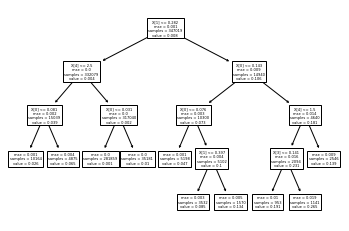

In [67]:
plot_tree(dt);

In [68]:
dt.get_n_leaves(), len(train_xs)

(10, 347019)

In [69]:
train_rmse = rmse(dt.predict(train_xs), train_y)
valid_rmse = rmse(dt.predict(valid_xs), valid_y)

In [70]:
std = data.describe().to_dict()['pop2012']['std']
R2 = 1 - ( valid_rmse / std ) ** 2
train_rmse, valid_rmse, R2

(0.01854136212813236, 0.019107495651808807, 0.647980948210392)

## Random Forest

In [71]:
n_estimators = 500
max_samples = 200_000
max_features = 0.5
min_samples_leaf = 5

In [72]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
    max_samples=max_samples, max_features=max_features,
    min_samples_leaf=min_samples_leaf, oob_score=True)

In [73]:
import time
start = time.time()
m = rf.fit(train_xs, train_y);
end = time.time()
print("Time:", end-start)

Time: 147.43240976333618


In [74]:
train_rmse = rmse(rf.predict(train_xs), train_y)
valid_rmse = rmse(rf.predict(valid_xs), valid_y)

In [75]:
R2 = 1 - ( valid_rmse / std ) ** 2
train_rmse, valid_rmse, R2

(0.012706929286554905, 0.015377206419442587, 0.7720111970000118)

In [76]:
train_preds = np.stack([t.predict(train_xs) for t in rf.estimators_])
valid_preds = np.stack([t.predict(valid_xs) for t in rf.estimators_])
train_preds.shape, valid_preds.shape

((500, 347019), (500, 86755))

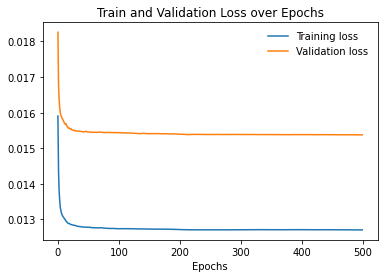

In [77]:
t = [rmse(train_preds[:i+1].mean(0), train_y) for i in range(0, n_estimators)]
v = [rmse(valid_preds[:i+1].mean(0), valid_y) for i in range(0, n_estimators)]

plt.plot(t, label='Training loss')
plt.plot(v, label='Validation loss')
plt.title("Train and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.legend(frameon=False)

In [78]:
for name, score in zip(alist[1:], rf.feature_importances_):
    print('%s: %f' %(name, 100 *score)+"%")

night2012: 23.820818%
road_len: 40.410091%
cen_dist: 6.306849%
city_pop_total: 5.490294%
land_cover: 23.971948%


## Gradient Boosting

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'n_estimators':[10], 'max_depth': [8, 10, 12], 'learning_rate':[0.1, 0.3, 0.5], 'min_samples_leaf':[15]}]
gbrt_test = GradientBoostingRegressor()

In [ ]:
grid_search = GridSearchCV(gbrt_test, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(xs,y)

In [ ]:
grid_search.best_params_

In [ ]:
print(1))

In [84]:
n_estimators = 500
max_depth = 10
lr = 0.3
min_samples_leaf = 15

In [85]:
gbrt = GradientBoostingRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=lr, min_samples_leaf=min_samples_leaf)
m = gbrt.fit(xs,y)

In [86]:
errors = [rmse(valid_y_pred, valid_y) for valid_y_pred in gbrt.staged_predict(valid_xs)]
best_n_estimators = np.argmin(errors)
print(best_n_estimators)

499


In [ ]:
gbrt_best = GradientBoostingRegressor(max_depth=max_depth, n_estimators=best_n_estimators)
m = gbrt_best.fit(xs,y)

In [88]:
train_rmse = rmse(m.predict(train_xs), train_y)
valid_rmse = rmse(m.predict(valid_xs), valid_y)

In [89]:
R2 = 1 - ( valid_rmse / std ) ** 2
train_rmse, valid_rmse, R2

(0.007522145734310475, 0.00752718591557469, 0.9453709163488232)

In [90]:
for name, score in zip(alist[1:], m.feature_importances_):
    print('%s: %f' %(name, 100 *score)+"%")

night2012: 21.830126%
road_len: 54.279039%
cen_dist: 6.983971%
city_pop_total: 6.232950%
land_cover: 10.673913%


In [100]:
# Save the model
joblib_file = "gbrt.pkl"
joblib.dump(m, path+r"/"+joblib_file)
print('Model Saved!')

Model Saved!


## Now Prediction!

In [101]:
# predict with the model
data = pd.read_csv(path+"/data_new.csv")
to = TabularPandas(data, procs, cat, cont, y_names=y_names)
xs, y = to.xs, to.y

In [102]:
# Load from file
joblib_file = "gbrt.pkl"
joblib_model = joblib.load(path+r"/"+joblib_file)

In [103]:
preds = joblib_model.predict(xs)

In [104]:
# Transform to the pre-normalized state
maxi = 57586.267532
preds = preds * maxi

In [105]:
# Copy in the csv
data = pd.read_csv(path+r"/data.csv")
data['pop_pred_RF'] = preds

In [106]:
data.head()

,fid,fua_name,road_len,pop2012,night2012,cen_dist,city_pop_total,CLC2012,pop_pred_RF
0,1,Acireale,0.015348,7325.648926,30.059999,2692.726152,65551.67962,1,7518.218849
1,2,Acireale,0.007960,1882.117426,20.930000,2421.478762,65551.67962,1,2127.901419
2,3,Acireale,0.006610,2574.318192,18.379999,2214.927460,65551.67962,1,2563.445263
3,4,Acireale,0.011870,7405.131897,28.459999,2092.320938,65551.67962,1,6007.991293
4,5,Acireale,0.013190,11867.653830,42.959999,2068.639445,65551.67962,1,10160.673873


In [107]:
data.to_csv(path+r"/data_preds.csv",index=False)
print('File Exported!')

File Exported!
